## Modelagem

A modelagem é parecida com a do desafio anteior, no entanto sem utilizar os dados de 2016 no treino, somente os dados de 2017 por ser mais próximo do ano seguinte. Além disso o modelo só utilizou os meses de jan,fev e mar para treinamento dos modelo, já que o comportamento entre os anos, através dos dados feitos no notebook de exploração, mostr um comportamento sazonal e bem próximo no dado um mesmo período de tempo. 

Para as features categóricas foi utilizado o método one-hot-encoder. 

* removed_nan = all_data.dropna(0,subset=["2017_1"]) - Remove os labels NaN de acordo com o mês. Aplicado para fev e mar também
* X['População total 2017'] = X['População total 2017'].astype(float) - Transform a população em float e coloca NaN naqueles campos que não possuem dados. 
* Métrica: neg_root_mean_squared 
* Três tipos de modelos
    * Somente com meses
    * Meses + metadados da loja + população
    * Meses + metadados da loja + população +  (IDHM, PIP)

In [1]:
#imports
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import sys
import seaborn as sns
import re
sns.set_style('darkgrid')

import xgboost
from sklearn.model_selection import train_test_split,cross_val_score, KFold
from sklearn.metrics import accuracy_score,mean_squared_error
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn import tree
from xgboost import plot_importance
from sklearn.model_selection import RandomizedSearchCV


def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [2]:
cenarios = pd.read_csv('./data/cenarios_expansao.csv')

faturamento = pd.read_csv('./data/faturamento_lojas_atuais.csv')

lojas = pd.read_csv('./data/lojas_atuais.csv')

idh_capita = pd.read_excel('./data/AtlasBrasil_Consulta.xlsx')

mun_populacao_2017 = pd.read_excel('./data/populacao_2017.xlsx')

In [3]:
idh_capita.head()

Código       Espacialidades  IDHM 2010  IDHM Renda 2010  \
0       76               Brasil      0.727            0.739   
1  5200050      Abadia de Goiás      0.708            0.687   
2  3100104  Abadia dos Dourados      0.689            0.693   
3  5200100            Abadiânia      0.689            0.671   
4  3100203               Abaeté      0.698            0.720   

   IDHM Longevidade 2010  Renda per capita 2010  
0                  0.816                 793.87  
1                  0.830                 574.96  
2                  0.839                 596.18  
3                  0.841                 519.87  
4                  0.848                 707.24

In [4]:
mun_populacao_2017.head()

Territorialidades População total 2017
0                    Brasil            207660929
1      Abadia de Goiás (GO)                 8207
2  Abadia dos Dourados (MG)                 7059
3            Abadiânia (GO)                18775
4               Abaeté (MG)                23611

In [5]:
def remove_state(string_data):
  return (re.sub(" \([^)]*\)", "",string_data))

In [6]:
mun_populacao_2017["Territorialidades"] = mun_populacao_2017["Territorialidades"].apply(lambda x: remove_state(x))
mun_populacao_2017.head()

Territorialidades População total 2017
0               Brasil            207660929
1      Abadia de Goiás                 8207
2  Abadia dos Dourados                 7059
3            Abadiânia                18775
4               Abaeté                23611

In [7]:
mun_populacao_2017.columns = ["Espacialidades","População total 2017"]
print(mun_populacao_2017)

                                         Espacialidades População total 2017
0                                                Brasil            207660929
1                                       Abadia de Goiás                 8207
2                                   Abadia dos Dourados                 7059
3                                             Abadiânia                18775
4                                                Abaeté                23611
...                                                 ...                  ...
5563                                            Zé Doca                51084
5564                                             Zortéa                 3300
5565                                                                        
5566  Elaboração: Atlas do Desenvolvimento Humano no...                  NaN
5567  Fontes: dados do IBGE e de registros administr...                  NaN

[5568 rows x 2 columns]


In [8]:
mun_populacao_2017  = mun_populacao_2017.drop_duplicates(subset=["Espacialidades"], keep="last")

In [9]:
metadata = mun_populacao_2017.merge(idh_capita,on="Espacialidades")
metadata.head()


Espacialidades População total 2017   Código  IDHM 2010  \
0               Brasil            207660929       76      0.727   
1      Abadia de Goiás                 8207  5200050      0.708   
2  Abadia dos Dourados                 7059  3100104      0.689   
3            Abadiânia                18775  5200100      0.689   
4               Abaeté                23611  3100203      0.698   

   IDHM Renda 2010  IDHM Longevidade 2010  Renda per capita 2010  
0            0.739                  0.816                 793.87  
1            0.687                  0.830                 574.96  
2            0.693                  0.839                 596.18  
3            0.671                  0.841                 519.87  
4            0.720                  0.848                 707.24

In [10]:
feature_01_dummy = pd.get_dummies(lojas.feature_01)
feature_02_dummy = pd.get_dummies(lojas.feature_02)
feature_05_dummy = pd.get_dummies(lojas.feature_05)
feature_11_dummy = pd.get_dummies(lojas.feature_11)
feature_12_dummy = pd.get_dummies(lojas.feature_12)
hot_encoded_lojas = pd.concat([lojas,feature_01_dummy,feature_02_dummy,feature_05_dummy,feature_11_dummy,feature_12_dummy],axis=1)
hot_encoded_lojas.head()

cod_loja         cod_ap  cod_municipio           feature_01  \
0         1  4125506005002        4125506                  NaN   
1         2  5300108005004        5300108                  NaN   
2         3  3550308005052        3550308                  NaN   
3         4  3145604003002        3145604                  NaN   
4         5  1600303005010        1600303  FEATURE_01_VALUE_10   

            feature_02  feature_03  feature_04           feature_05  \
0  FEATURE_02_VALUE_04        True       21.76  FEATURE_05_VALUE_04   
1  FEATURE_02_VALUE_03        True       22.00  FEATURE_05_VALUE_03   
2  FEATURE_02_VALUE_03        True       45.66  FEATURE_05_VALUE_03   
3  FEATURE_02_VALUE_04       False       30.00  FEATURE_05_VALUE_03   
4  FEATURE_02_VALUE_02       False       62.49  FEATURE_05_VALUE_03   

   feature_06  feature_07  ...  FEATURE_05_VALUE_08  FEATURE_11_VALUE_01  \
0          31    0.168922  ...                    0                    0   
1          27    0.215967  ...                    0                    0   
2           6    0.190102  ...                    0                    0   
3           3    0.141988  ...                    0                    0   
4          30    0.107619  ...                    0                    0   

   FEATURE_11_VALUE_02 FEATURE_11_VALUE_03 FEATURE_11_VALUE_04  \
0                    0                   0                   0   
1                    0                   0                   0   
2                    0                   0                   0   
3                    0                   0                   0   
4                    1                   0                   0   

   FEATURE_11_VALUE_05  FEATURE_11_VALUE_06  FEATURE_11_VALUE_07  \
0                    0                    0                    0   
1                    0                    0                    0   
2                    0                    0                    0   
3                    0                    0                    0   
4                    0                    0                    0   

   FEATURE_12_VALUE_01  FEATURE_12_VALUE_02  
0                    0                    0  
1                    0                    0  
2                    0                    0  
3                    0                    0  
4                    1                    0  

[5 rows x 46 columns]

In [11]:
hot_encoded_lojas = hot_encoded_lojas.drop(columns=["feature_01","feature_02","feature_05","feature_11","feature_12"])
hot_encoded_lojas.head()

cod_loja         cod_ap  cod_municipio  feature_03  feature_04  feature_06  \
0         1  4125506005002        4125506        True       21.76          31   
1         2  5300108005004        5300108        True       22.00          27   
2         3  3550308005052        3550308        True       45.66           6   
3         4  3145604003002        3145604       False       30.00           3   
4         5  1600303005010        1600303       False       62.49          30   

   feature_07  feature_08   feature_09  feature_10  ...  FEATURE_05_VALUE_08  \
0    0.168922    0.167659   115.958848    2.349821  ...                    0   
1    0.215967    0.197287  1562.674817    3.670883  ...                    0   
2    0.190102    0.179140  5593.905463    2.815883  ...                    0   
3    0.141988    0.143677    12.824022    7.218132  ...                    0   
4    0.107619    0.103083   325.531120    1.972944  ...                    0   

   FEATURE_11_VALUE_01  FEATURE_11_VALUE_02  FEATURE_11_VALUE_03  \
0                    0                    0                    0   
1                    0                    0                    0   
2                    0                    0                    0   
3                    0                    0                    0   
4                    0                    1                    0   

   FEATURE_11_VALUE_04  FEATURE_11_VALUE_05  FEATURE_11_VALUE_06  \
0                    0                    0                    0   
1                    0                    0                    0   
2                    0                    0                    0   
3                    0                    0                    0   
4                    0                    0                    0   

   FEATURE_11_VALUE_07  FEATURE_12_VALUE_01  FEATURE_12_VALUE_02  
0                    0                    0                    0  
1                    0                    0                    0  
2                    0                    0                    0  
3                    0                    0                    0  
4                    0                    1                    0  

[5 rows x 41 columns]

In [12]:
hot_encoded_lojas.shape

(3130, 41)

In [13]:
metadata_lojas = hot_encoded_lojas.merge(metadata,how="inner",left_on="cod_municipio",right_on="Código")
metadata_lojas.head()

cod_loja         cod_ap  cod_municipio  feature_03  feature_04  feature_06  \
0         1  4125506005002        4125506        True       21.76          31   
1       140  4125506005001        4125506        True       56.84           9   
2      1205  4125506005002        4125506        True       29.30           1   
3      1305  4125506005001        4125506        True       20.60           1   
4      1610  4125506005001        4125506        True       63.58           6   

   feature_07  feature_08  feature_09  feature_10  ...  FEATURE_11_VALUE_07  \
0    0.168922    0.167659  115.958848    2.349821  ...                    0   
1    0.168922    0.167659  115.958848    2.349821  ...                    0   
2    0.168922    0.167659  115.958848    2.349821  ...                    0   
3    0.168922    0.167659  115.958848    2.349821  ...                    0   
4    0.168922    0.167659  115.958848    2.349821  ...                    0   

   FEATURE_12_VALUE_01  FEATURE_12_VALUE_02        Espacialidades  \
0                    0                    0  São José dos Pinhais   
1                    0                    0  São José dos Pinhais   
2                    0                    0  São José dos Pinhais   
3                    0                    1  São José dos Pinhais   
4                    0                    0  São José dos Pinhais   

   População total 2017   Código  IDHM 2010  IDHM Renda 2010  \
0                307530  4125506      0.758            0.749   
1                307530  4125506      0.758            0.749   
2                307530  4125506      0.758            0.749   
3                307530  4125506      0.758            0.749   
4                307530  4125506      0.758            0.749   

   IDHM Longevidade 2010  Renda per capita 2010  
0                  0.859                 846.93  
1                  0.859                 846.93  
2                  0.859                 846.93  
3                  0.859                 846.93  
4                  0.859                 846.93  

[5 rows x 48 columns]

In [14]:
# Verificar a correlação entre média de de 2016 e 2017 
grouped_loja_ano_mes = faturamento.groupby(["cod_loja","ano","mes"]).sum().reset_index()
grouped_loja_ano_mes

cod_loja   ano  mes     qtde    receita
0             1  2016    1  13034.0  441833.37
1             1  2016    2  11411.0  395340.22
2             1  2016    3  15030.0  587810.18
3             1  2016    4  12726.0  534618.84
4             1  2016    5  13978.0  595477.92
...         ...   ...  ...      ...        ...
73639      3687  2017    8   1864.0   71171.48
73640      3687  2017    9   1257.0   48284.66
73641      3687  2017   10   1709.0   61198.10
73642      3687  2017   11   2039.0   73877.02
73643      3687  2017   12   4398.0  186545.24

[73644 rows x 5 columns]

In [15]:
filtered_month = grouped_loja_ano_mes[(grouped_loja_ano_mes["mes"] == 1) | (grouped_loja_ano_mes["mes"] == 2)  | (grouped_loja_ano_mes["mes"] == 3)]
filtered_month

cod_loja   ano  mes     qtde    receita
0             1  2016    1  13034.0  441833.37
1             1  2016    2  11411.0  395340.22
2             1  2016    3  15030.0  587810.18
12            1  2017    1  10065.0  404108.77
13            1  2017    2  11107.0  483610.18
...         ...   ...  ...      ...        ...
73621      3687  2016    2   1269.0   40147.63
73622      3687  2016    3   1597.0   56621.60
73632      3687  2017    1   1317.0   49269.30
73633      3687  2017    2   1153.0   39229.17
73634      3687  2017    3   1789.0   63369.27

[18338 rows x 5 columns]

In [16]:
filtered_month['mes_ano'] = filtered_month[['ano', 'mes']].astype(str).apply(lambda x: '_'.join(x), axis=1)
filtered_month

/home/felipemarcelino/.conda/envs/hackaton_big_data/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


cod_loja   ano  mes     qtde    receita mes_ano
0             1  2016    1  13034.0  441833.37  2016_1
1             1  2016    2  11411.0  395340.22  2016_2
2             1  2016    3  15030.0  587810.18  2016_3
12            1  2017    1  10065.0  404108.77  2017_1
13            1  2017    2  11107.0  483610.18  2017_2
...         ...   ...  ...      ...        ...     ...
73621      3687  2016    2   1269.0   40147.63  2016_2
73622      3687  2016    3   1597.0   56621.60  2016_3
73632      3687  2017    1   1317.0   49269.30  2017_1
73633      3687  2017    2   1153.0   39229.17  2017_2
73634      3687  2017    3   1789.0   63369.27  2017_3

[18338 rows x 6 columns]

In [17]:
filtered_month_pivoted = filtered_month.pivot_table("receita",["cod_loja"],["mes_ano"])
filtered_month_pivoted

mes_ano      2016_1     2016_2     2016_3     2017_1     2017_2     2017_3
cod_loja                                                                  
1         441833.37  395340.22  587810.18  404108.77  483610.18  626291.59
2          54660.39   49120.72   53421.91   55235.99   39019.13   62446.56
3         161428.96  132417.93  139495.61  131512.12  130868.47  141768.81
4          54363.21   38433.23   43751.17   48694.93   42445.06   51014.55
5         248834.01  182297.02  210579.83  192211.08  151167.08  177428.43
...             ...        ...        ...        ...        ...        ...
3682      121727.10   96526.36  150817.29  106572.49  105736.48  132543.17
3683      190014.89  107871.65  125584.12  167519.47  129491.36  130658.08
3685      187775.61  145430.99  184151.12  182564.30  125240.48  192202.86
3686       85259.81   53781.67   49293.02   78711.76   63761.34   62940.56
3687       48988.51   40147.63   56621.60   49269.30   39229.17   63369.27

[3090 rows x 6 columns]

In [18]:
filtered_month_pivoted['cod_loja'] = filtered_month_pivoted.index
filtered_month_pivoted.index.names = ["cod_index"]
filtered_month_pivoted.head()

mes_ano       2016_1     2016_2     2016_3     2017_1     2017_2     2017_3  \
cod_index                                                                     
1          441833.37  395340.22  587810.18  404108.77  483610.18  626291.59   
2           54660.39   49120.72   53421.91   55235.99   39019.13   62446.56   
3          161428.96  132417.93  139495.61  131512.12  130868.47  141768.81   
4           54363.21   38433.23   43751.17   48694.93   42445.06   51014.55   
5          248834.01  182297.02  210579.83  192211.08  151167.08  177428.43   

mes_ano    cod_loja  
cod_index            
1                 1  
2                 2  
3                 3  
4                 4  
5                 5

In [19]:
data = metadata_lojas.merge(filtered_month_pivoted,on="cod_loja",how="left")
data.head()

cod_loja         cod_ap  cod_municipio  feature_03  feature_04  feature_06  \
0         1  4125506005002        4125506        True       21.76          31   
1       140  4125506005001        4125506        True       56.84           9   
2      1205  4125506005002        4125506        True       29.30           1   
3      1305  4125506005001        4125506        True       20.60           1   
4      1610  4125506005001        4125506        True       63.58           6   

   feature_07  feature_08  feature_09  feature_10  ...  IDHM 2010  \
0    0.168922    0.167659  115.958848    2.349821  ...      0.758   
1    0.168922    0.167659  115.958848    2.349821  ...      0.758   
2    0.168922    0.167659  115.958848    2.349821  ...      0.758   
3    0.168922    0.167659  115.958848    2.349821  ...      0.758   
4    0.168922    0.167659  115.958848    2.349821  ...      0.758   

   IDHM Renda 2010  IDHM Longevidade 2010  Renda per capita 2010     2016_1  \
0            0.749                  0.859                 846.93  441833.37   
1            0.749                  0.859                 846.93  183519.18   
2            0.749                  0.859                 846.93   53845.51   
3            0.749                  0.859                 846.93   53922.72   
4            0.749                  0.859                 846.93  211876.56   

      2016_2     2016_3     2017_1     2017_2     2017_3  
0  395340.22  587810.18  404108.77  483610.18  626291.59  
1  127751.96  151379.97  180857.94  127568.94  189205.05  
2   41153.12   47994.36   47277.50   42168.71   55975.56  
3   44761.70   47498.39   53024.46   44005.19   57864.03  
4  148266.09  160381.81  188363.66  156484.33  174045.49  

[5 rows x 54 columns]

In [20]:
data.columns

Index(['cod_loja', 'cod_ap', 'cod_municipio', 'feature_03', 'feature_04',
       'feature_06', 'feature_07', 'feature_08', 'feature_09', 'feature_10',
       'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17',
       'feature_18', 'FEATURE_01_VALUE_03', 'FEATURE_01_VALUE_06',
       'FEATURE_01_VALUE_08', 'FEATURE_01_VALUE_10', 'FEATURE_02_VALUE_02',
       'FEATURE_02_VALUE_03', 'FEATURE_02_VALUE_04', 'FEATURE_02_VALUE_06',
       'FEATURE_05_VALUE_01', 'FEATURE_05_VALUE_02', 'FEATURE_05_VALUE_03',
       'FEATURE_05_VALUE_04', 'FEATURE_05_VALUE_05', 'FEATURE_05_VALUE_06',
       'FEATURE_05_VALUE_07', 'FEATURE_05_VALUE_08', 'FEATURE_11_VALUE_01',
       'FEATURE_11_VALUE_02', 'FEATURE_11_VALUE_03', 'FEATURE_11_VALUE_04',
       'FEATURE_11_VALUE_05', 'FEATURE_11_VALUE_06', 'FEATURE_11_VALUE_07',
       'FEATURE_12_VALUE_01', 'FEATURE_12_VALUE_02', 'Espacialidades',
       'População total 2017', 'Código', 'IDHM 2010', 'IDHM Renda 2010',
       'IDHM Longevidade 2010

In [21]:
data["População total 2017"] = data["População total 2017"].astype(float)

In [22]:
feature_01_dummy = pd.get_dummies(cenarios.feature_01)
feature_02_dummy = pd.get_dummies(cenarios.feature_02)
feature_05_dummy = pd.get_dummies(cenarios.feature_05)
feature_11_dummy = pd.get_dummies(cenarios.feature_11)
feature_12_dummy = pd.get_dummies(cenarios.feature_12)
hot_encoded_cenarios = pd.concat([cenarios,feature_01_dummy,feature_02_dummy,feature_05_dummy,feature_11_dummy,feature_12_dummy],axis=1)
hot_encoded_cenarios = hot_encoded_cenarios.drop(columns=["feature_01","feature_02","feature_05","feature_11","feature_12"])
hot_encoded_cenarios.head()

cod_loja         cod_ap  cod_municipio  feature_03  feature_04  feature_06  \
0        10  2933307005008        2933307       False       50.00           6   
1        13  2916401003002        2916401       False       41.00           4   
2        16  2928703003003        2928703       False       42.12           2   
3        21  2906006003001        2906006       False       30.00           6   
4        28  3550308005058        3550308        True       44.31           8   

   feature_07  feature_08   feature_09  feature_10  ...  FEATURE_05_VALUE_04  \
0    0.134654    0.131481   116.194058    2.913498  ...                    0   
1    0.116662    0.114995    26.345742    1.312612  ...                    0   
2    0.104162    0.087807    35.362788    1.969512  ...                    0   
3    0.132954    0.131330     9.862757    1.383681  ...                    0   
4    0.190102    0.179140  5593.905463    2.815883  ...                    0   

   FEATURE_05_VALUE_05  FEATURE_05_VALUE_06  FEATURE_05_VALUE_07  \
0                    0                    0                    0   
1                    0                    0                    0   
2                    1                    0                    0   
3                    0                    0                    0   
4                    0                    0                    0   

   FEATURE_11_VALUE_01  FEATURE_11_VALUE_02  FEATURE_11_VALUE_06  \
0                    1                    0                    0   
1                    0                    0                    0   
2                    0                    0                    0   
3                    0                    0                    0   
4                    0                    1                    0   

   FEATURE_11_VALUE_07  FEATURE_12_VALUE_01  FEATURE_12_VALUE_02  
0                    0                    1                    0  
1                    0                    0                    0  
2                    0                    0                    0  
3                    0                    0                    0  
4                    0                    1                    0  

[5 rows x 37 columns]

In [23]:
metadata_cenarios = hot_encoded_cenarios.merge(metadata,how="left",left_on="cod_municipio",right_on="Código")
metadata_cenarios.head()

cod_loja         cod_ap  cod_municipio  feature_03  feature_04  feature_06  \
0        10  2933307005008        2933307       False       50.00           6   
1        13  2916401003002        2916401       False       41.00           4   
2        16  2928703003003        2928703       False       42.12           2   
3        21  2906006003001        2906006       False       30.00           6   
4        28  3550308005058        3550308        True       44.31           8   

   feature_07  feature_08   feature_09  feature_10  ...  FEATURE_11_VALUE_07  \
0    0.134654    0.131481   116.194058    2.913498  ...                    0   
1    0.116662    0.114995    26.345742    1.312612  ...                    0   
2    0.104162    0.087807    35.362788    1.969512  ...                    0   
3    0.132954    0.131330     9.862757    1.383681  ...                    0   
4    0.190102    0.179140  5593.905463    2.815883  ...                    0   

   FEATURE_12_VALUE_01  FEATURE_12_VALUE_02          Espacialidades  \
0                    1                    0    Vitória da Conquista   
1                    0                    0              Itapetinga   
2                    0                    0  Santo Antônio de Jesus   
3                    0                    0           Campo Formoso   
4                    1                    0               São Paulo   

   População total 2017     Código  IDHM 2010  IDHM Renda 2010  \
0                348718  2933307.0      0.678            0.681   
1                 77533  2916401.0      0.667            0.667   
2                103342  2928703.0      0.700            0.677   
3                 73448  2906006.0      0.586            0.566   
4              12106920  3550308.0      0.805            0.843   

   IDHM Longevidade 2010  Renda per capita 2010  
0                  0.788                 555.66  
1                  0.790                 506.76  
2                  0.815                 540.38  
3                  0.749                 270.05  
4                  0.855                1516.21  

[5 rows x 44 columns]

In [24]:
metadata_cenarios["População total 2017"] = metadata_cenarios["População total 2017"].astype(float)

### Sem usar os dados de IDH e de população

In [25]:
removed_nan = data.dropna(0,subset=["2017_1"])

In [26]:
features = ['cod_municipio', 'feature_03', 'feature_04',
       'feature_06', 'feature_07', 'feature_08', 'feature_09', 'feature_10',
       'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17',
       'feature_18', 'FEATURE_01_VALUE_03', 'FEATURE_01_VALUE_06',
       'FEATURE_01_VALUE_08', 'FEATURE_01_VALUE_10', 'FEATURE_02_VALUE_02',
       'FEATURE_02_VALUE_03', 'FEATURE_02_VALUE_04', 'FEATURE_02_VALUE_06',
       'FEATURE_05_VALUE_01', 'FEATURE_05_VALUE_02', 'FEATURE_05_VALUE_03',
       'FEATURE_05_VALUE_04', 'FEATURE_05_VALUE_05', 'FEATURE_05_VALUE_06',
       'FEATURE_05_VALUE_07', 'FEATURE_11_VALUE_01',
       'FEATURE_11_VALUE_02', 'FEATURE_11_VALUE_06', 
       'FEATURE_11_VALUE_07', 'FEATURE_12_VALUE_01', 'FEATURE_12_VALUE_02']
X = removed_nan[features]
target = ['2017_1']
Y = removed_nan[target]

In [27]:
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

In [28]:
model_jan = xgboost.XGBRegressor(objective="reg:squarederror", random_state=42)

In [29]:
score = cross_val_score(model_jan, X_train, y_train, scoring="neg_root_mean_squared_error", cv=5)
display_scores(np.sqrt(-score))

Scores: [211.46904359 204.61908169 209.95873883 210.24936426 209.926192  ]
Mean: 209.2444840731696
Standard deviation: 2.380238727970781


In [30]:
model_jan = model_jan.fit(X_train, y_train)
y_pred = model_jan.predict(X_test)
mean_squared_error(y_test,y_pred)

1691359541.0418816

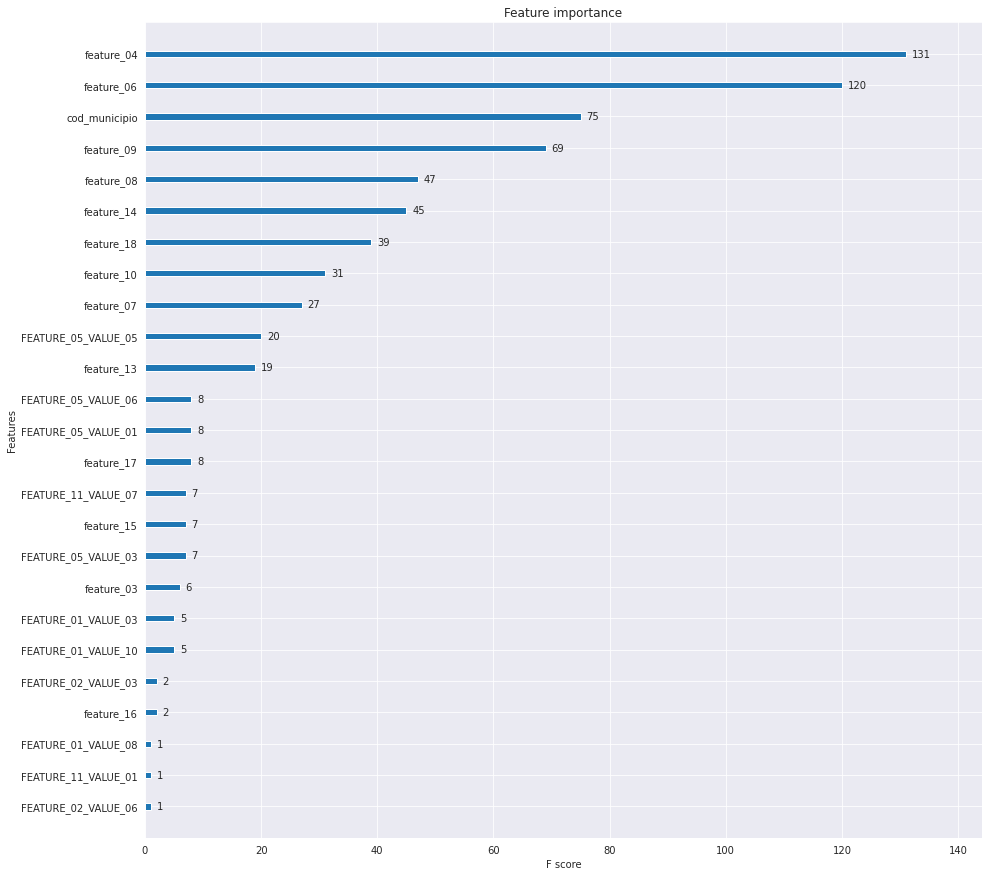

In [31]:
# plot feature importance
fig, ax = plt.subplots(1,1,figsize=(15,15))
plot_importance(model_jan, ax=ax)
plt.show()

In [32]:
removed_nan = data.dropna(0,subset=["2017_2"])

In [33]:
features = ['cod_municipio', 'feature_03', 'feature_04',
       'feature_06', 'feature_07', 'feature_08', 'feature_09', 'feature_10',
       'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17',
       'feature_18', 'FEATURE_01_VALUE_03', 'FEATURE_01_VALUE_06',
       'FEATURE_01_VALUE_08', 'FEATURE_01_VALUE_10', 'FEATURE_02_VALUE_02',
       'FEATURE_02_VALUE_03', 'FEATURE_02_VALUE_04', 'FEATURE_02_VALUE_06',
       'FEATURE_05_VALUE_01', 'FEATURE_05_VALUE_02', 'FEATURE_05_VALUE_03',
       'FEATURE_05_VALUE_04', 'FEATURE_05_VALUE_05', 'FEATURE_05_VALUE_06',
       'FEATURE_05_VALUE_07', 'FEATURE_11_VALUE_01',
       'FEATURE_11_VALUE_02', 'FEATURE_11_VALUE_06', 
       'FEATURE_11_VALUE_07', 'FEATURE_12_VALUE_01', 'FEATURE_12_VALUE_02']
X = removed_nan[features]
target = ['2017_2']
Y = removed_nan[target]

In [34]:
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

In [35]:
model_fev = xgboost.XGBRegressor(objective="reg:squarederror", random_state=42)

In [36]:
score = cross_val_score(model_fev, X_train, y_train, scoring="neg_root_mean_squared_error", cv=5)
display_scores(np.sqrt(-score))

Scores: [194.80968766 191.27043453 188.43191909 191.29277915 188.9326729 ]
Mean: 190.9474986657196
Standard deviation: 2.2595430271886427


In [37]:
model_fev = model_fev.fit(X_train, y_train)
y_pred = model_fev.predict(X_test)
mean_squared_error(y_test,y_pred)

1344249711.646313

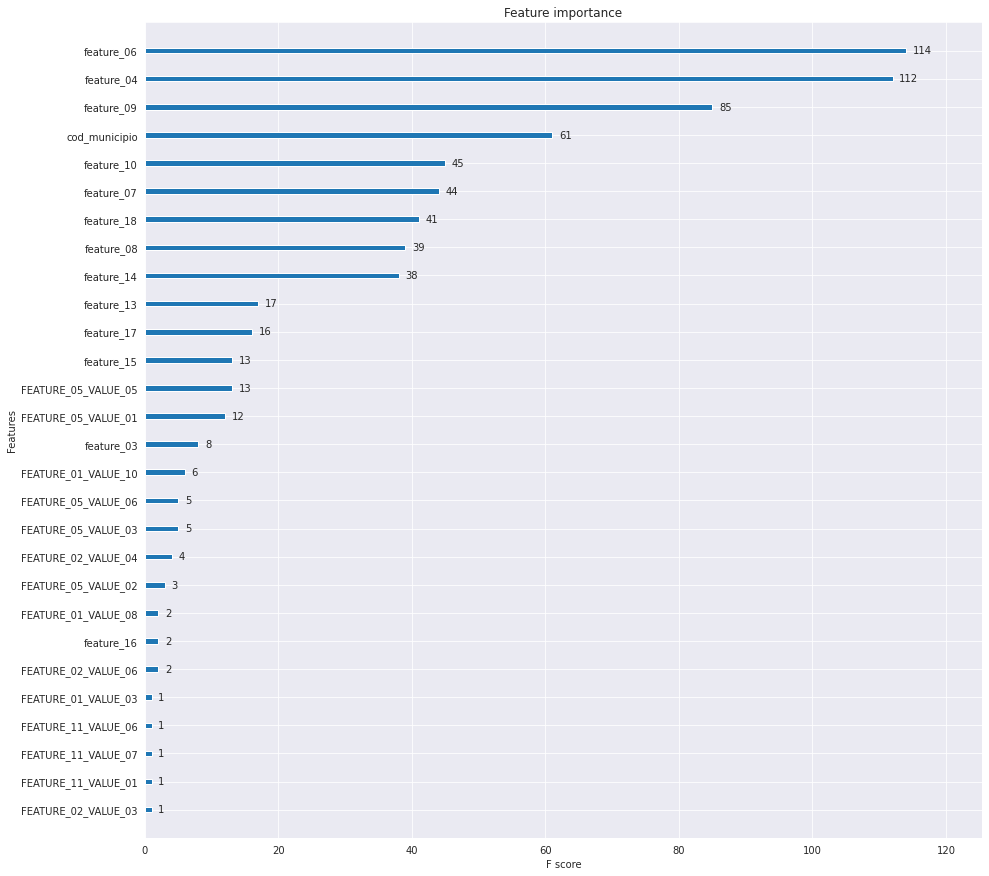

In [38]:
# plot feature importance
fig, ax = plt.subplots(1,1,figsize=(15,15))
plot_importance(model_fev, ax=ax)
plt.show()

In [39]:
removed_nan = data.dropna(0,subset=["2017_3"])

In [40]:
features = ['cod_municipio', 'feature_03', 'feature_04',
       'feature_06', 'feature_07', 'feature_08', 'feature_09', 'feature_10',
       'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17',
       'feature_18', 'FEATURE_01_VALUE_03', 'FEATURE_01_VALUE_06',
       'FEATURE_01_VALUE_08', 'FEATURE_01_VALUE_10', 'FEATURE_02_VALUE_02',
       'FEATURE_02_VALUE_03', 'FEATURE_02_VALUE_04', 'FEATURE_02_VALUE_06',
       'FEATURE_05_VALUE_01', 'FEATURE_05_VALUE_02', 'FEATURE_05_VALUE_03',
       'FEATURE_05_VALUE_04', 'FEATURE_05_VALUE_05', 'FEATURE_05_VALUE_06',
       'FEATURE_05_VALUE_07', 'FEATURE_11_VALUE_01',
       'FEATURE_11_VALUE_02', 'FEATURE_11_VALUE_06', 
       'FEATURE_11_VALUE_07', 'FEATURE_12_VALUE_01', 'FEATURE_12_VALUE_02']
X = removed_nan[features]
target = ['2017_3']
Y = removed_nan[target]

In [41]:
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

In [42]:
model_mar = xgboost.XGBRegressor(objective="reg:squarederror", random_state=42)

In [43]:
score = cross_val_score(model_mar, X_train, y_train, scoring="neg_root_mean_squared_error", cv=5)
display_scores(np.sqrt(-score))

Scores: [214.90051675 199.37031575 206.69272121 211.49807822 209.10123229]
Mean: 208.3125728437868
Standard deviation: 5.2298817282146866


In [44]:
model_mar= model_mar.fit(X_train, y_train)
y_pred = model_mar.predict(X_test)
mean_squared_error(y_test,y_pred)

1742131085.0023522

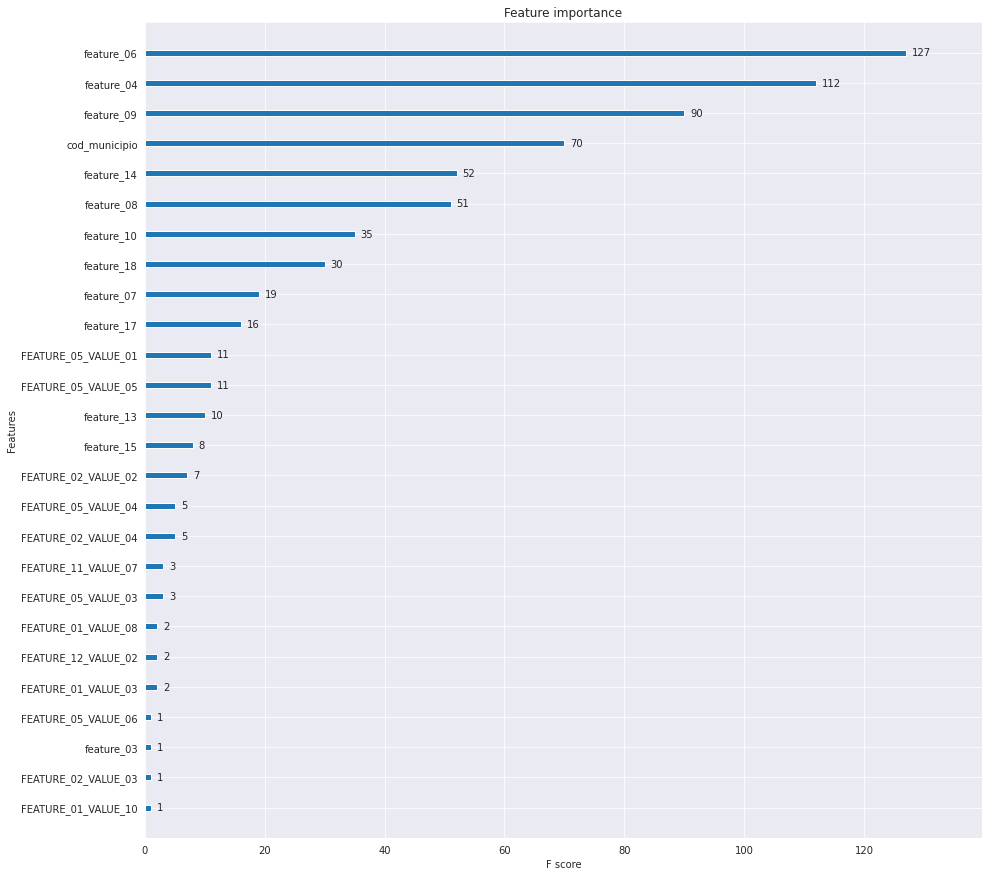

In [45]:
# plot feature importance
fig, ax = plt.subplots(1,1,figsize=(15,15))
plot_importance(model_mar, ax=ax)
plt.show()

In [46]:
cenarios

cod_loja         cod_ap  cod_municipio           feature_01  \
0          10  2933307005008        2933307  FEATURE_01_VALUE_08   
1          13  2916401003002        2916401  FEATURE_01_VALUE_10   
2          16  2928703003003        2928703                  NaN   
3          21  2906006003001        2906006                  NaN   
4          28  3550308005058        3550308  FEATURE_01_VALUE_10   
..        ...            ...            ...                  ...   
548      3667  2927408005009        2927408  FEATURE_01_VALUE_03   
549      3672             -1             -1                  NaN   
550      3674  5208707005001        5208707                  NaN   
551      3675  4218202003002        4218202                  NaN   
552      3684  2917607003002        2917607                  NaN   

              feature_02  feature_03  feature_04           feature_05  \
0    FEATURE_02_VALUE_02       False       50.00  FEATURE_05_VALUE_03   
1    FEATURE_02_VALUE_04       False       41.00  FEATURE_05_VALUE_03   
2    FEATURE_02_VALUE_04       False       42.12  FEATURE_05_VALUE_05   
3    FEATURE_02_VALUE_04       False       30.00  FEATURE_05_VALUE_03   
4    FEATURE_02_VALUE_02        True       44.31  FEATURE_05_VALUE_03   
..                   ...         ...         ...                  ...   
548  FEATURE_02_VALUE_03        True       11.47  FEATURE_05_VALUE_06   
549  FEATURE_02_VALUE_03       False       31.00  FEATURE_05_VALUE_05   
550  FEATURE_02_VALUE_03       False       58.00  FEATURE_05_VALUE_05   
551  FEATURE_02_VALUE_04       False       40.74  FEATURE_05_VALUE_03   
552  FEATURE_02_VALUE_04       False       29.00  FEATURE_05_VALUE_03   

     feature_06  feature_07  ...   feature_09  feature_10  \
0             6    0.134654  ...   116.194058    2.913498   
1             4    0.116662  ...    26.345742    1.312612   
2             2    0.104162  ...    35.362788    1.969512   
3             6    0.132954  ...     9.862757    1.383681   
4             8    0.190102  ...  5593.905463    2.815883   
..          ...         ...  ...          ...         ...   
548           3    0.107963  ...  1355.486603    4.142294   
549           5    0.190896  ...    32.409193    2.989030   
550           9    0.190896  ...   661.415873    2.795840   
551           4    0.133754  ...    20.027909    2.422305   
552           5    0.123648  ...    14.781510    1.803459   

              feature_11           feature_12 feature_13  feature_14  \
0    FEATURE_11_VALUE_01  FEATURE_12_VALUE_01      100.0        93.4   
1                    NaN                  NaN       84.3        77.5   
2                    NaN                  NaN        NaN         NaN   
3                    NaN                  NaN       85.0        76.9   
4    FEATURE_11_VALUE_02  FEATURE_12_VALUE_01        NaN         NaN   
..                   ...                  ...        ...         ...   
548                  NaN                  NaN        NaN         NaN   
549                  NaN                  NaN        NaN         NaN   
550                  NaN                  NaN      100.0        78.3   
551                  NaN                  NaN      100.0        92.5   
552                  NaN                  NaN       77.0       100.0   

     feature_15  feature_16  feature_17  feature_18  
0         100.0       100.0        71.7        88.8  
1         100.0       100.0        63.5        78.8  
2           NaN         NaN         NaN         NaN  
3         100.0       100.0       100.0        92.9  
4           NaN         NaN         NaN         NaN  
..          ...         ...         ...         ...  
548         NaN         NaN         NaN         NaN  
549         NaN         NaN         NaN         NaN  
550       100.0       100.0        60.6        81.1  
551       100.0       100.0        94.2        96.6  
552       100.0        50.0        99.7        85.6  

[553 rows x 21 columns]

In [47]:
feature_01_dummy = pd.get_dummies(cenarios.feature_01)
feature_02_dummy = pd.get_dummies(cenarios.feature_02)
feature_05_dummy = pd.get_dummies(cenarios.feature_05)
feature_11_dummy = pd.get_dummies(cenarios.feature_11)
feature_12_dummy = pd.get_dummies(cenarios.feature_12)
hot_encoded_cenarios = pd.concat([cenarios,feature_01_dummy,feature_02_dummy,feature_05_dummy,feature_11_dummy,feature_12_dummy],axis=1)
hot_encoded_cenarios = hot_encoded_cenarios.drop(columns=["feature_01","feature_02","feature_05","feature_11","feature_12"])
hot_encoded_cenarios.head()

cod_loja         cod_ap  cod_municipio  feature_03  feature_04  feature_06  \
0        10  2933307005008        2933307       False       50.00           6   
1        13  2916401003002        2916401       False       41.00           4   
2        16  2928703003003        2928703       False       42.12           2   
3        21  2906006003001        2906006       False       30.00           6   
4        28  3550308005058        3550308        True       44.31           8   

   feature_07  feature_08   feature_09  feature_10  ...  FEATURE_05_VALUE_04  \
0    0.134654    0.131481   116.194058    2.913498  ...                    0   
1    0.116662    0.114995    26.345742    1.312612  ...                    0   
2    0.104162    0.087807    35.362788    1.969512  ...                    0   
3    0.132954    0.131330     9.862757    1.383681  ...                    0   
4    0.190102    0.179140  5593.905463    2.815883  ...                    0   

   FEATURE_05_VALUE_05  FEATURE_05_VALUE_06  FEATURE_05_VALUE_07  \
0                    0                    0                    0   
1                    0                    0                    0   
2                    1                    0                    0   
3                    0                    0                    0   
4                    0                    0                    0   

   FEATURE_11_VALUE_01  FEATURE_11_VALUE_02  FEATURE_11_VALUE_06  \
0                    1                    0                    0   
1                    0                    0                    0   
2                    0                    0                    0   
3                    0                    0                    0   
4                    0                    1                    0   

   FEATURE_11_VALUE_07  FEATURE_12_VALUE_01  FEATURE_12_VALUE_02  
0                    0                    1                    0  
1                    0                    0                    0  
2                    0                    0                    0  
3                    0                    0                    0  
4                    0                    1                    0  

[5 rows x 37 columns]

In [48]:
metadata_cenarios = hot_encoded_cenarios.merge(metadata,how="left",left_on="cod_municipio",right_on="Código")
metadata_cenarios.head()

cod_loja         cod_ap  cod_municipio  feature_03  feature_04  feature_06  \
0        10  2933307005008        2933307       False       50.00           6   
1        13  2916401003002        2916401       False       41.00           4   
2        16  2928703003003        2928703       False       42.12           2   
3        21  2906006003001        2906006       False       30.00           6   
4        28  3550308005058        3550308        True       44.31           8   

   feature_07  feature_08   feature_09  feature_10  ...  FEATURE_11_VALUE_07  \
0    0.134654    0.131481   116.194058    2.913498  ...                    0   
1    0.116662    0.114995    26.345742    1.312612  ...                    0   
2    0.104162    0.087807    35.362788    1.969512  ...                    0   
3    0.132954    0.131330     9.862757    1.383681  ...                    0   
4    0.190102    0.179140  5593.905463    2.815883  ...                    0   

   FEATURE_12_VALUE_01  FEATURE_12_VALUE_02          Espacialidades  \
0                    1                    0    Vitória da Conquista   
1                    0                    0              Itapetinga   
2                    0                    0  Santo Antônio de Jesus   
3                    0                    0           Campo Formoso   
4                    1                    0               São Paulo   

   População total 2017     Código  IDHM 2010  IDHM Renda 2010  \
0                348718  2933307.0      0.678            0.681   
1                 77533  2916401.0      0.667            0.667   
2                103342  2928703.0      0.700            0.677   
3                 73448  2906006.0      0.586            0.566   
4              12106920  3550308.0      0.805            0.843   

   IDHM Longevidade 2010  Renda per capita 2010  
0                  0.788                 555.66  
1                  0.790                 506.76  
2                  0.815                 540.38  
3                  0.749                 270.05  
4                  0.855                1516.21  

[5 rows x 44 columns]

In [49]:
features = ['cod_municipio', 'feature_03', 'feature_04',
       'feature_06', 'feature_07', 'feature_08', 'feature_09', 'feature_10',
       'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17',
       'feature_18', 'FEATURE_01_VALUE_03', 'FEATURE_01_VALUE_06',
       'FEATURE_01_VALUE_08', 'FEATURE_01_VALUE_10', 'FEATURE_02_VALUE_02',
       'FEATURE_02_VALUE_03', 'FEATURE_02_VALUE_04', 'FEATURE_02_VALUE_06',
       'FEATURE_05_VALUE_01', 'FEATURE_05_VALUE_02', 'FEATURE_05_VALUE_03',
       'FEATURE_05_VALUE_04', 'FEATURE_05_VALUE_05', 'FEATURE_05_VALUE_06',
       'FEATURE_05_VALUE_07', 'FEATURE_11_VALUE_01',
       'FEATURE_11_VALUE_02', 'FEATURE_11_VALUE_06', 
       'FEATURE_11_VALUE_07', 'FEATURE_12_VALUE_01', 'FEATURE_12_VALUE_02']
X = metadata_cenarios[features]

In [50]:
sub = pd.DataFrame(columns=["cod_loja","faturamento","jan","fev","mar"])

In [51]:
sub["cod_loja"] = cenarios["cod_loja"].values

In [52]:
sub["jan"] = model_jan.predict(X)

In [53]:
sub["fev"] = model_fev.predict(X)

In [54]:
sub["mar"] = model_mar.predict(X)

In [55]:
sub["faturamento"] = (sub["jan"].values + sub["fev"].values + sub["mar"].values)/3

In [56]:
sub.head()

cod_loja    faturamento            jan            fev            mar
0        10  153912.390625  157102.796875  131404.515625  173229.859375
1        13  104506.992188  100154.632812   92441.828125  120924.492188
2        16   76308.093750   89204.234375   59091.425781   80628.632812
3        21   86783.484375   96921.562500   70698.132812   92730.765625
4        28  138840.796875  133057.312500  130031.070312  153434.031250

In [57]:
sub["faturamento"].sum()

53263616.0

In [58]:
sub.to_csv("./results/sub_2_v1.csv")

In [59]:
desafio_2 = sub[["cod_loja","faturamento"]]
desafio_2.head()

cod_loja    faturamento
0        10  153912.390625
1        13  104506.992188
2        16   76308.093750
3        21   86783.484375
4        28  138840.796875

In [60]:
desafio_2.to_csv("./results/desafio_2_v1.csv",index=False,sep=";")

In [61]:
desafio_2.shape

(553, 2)

### Usando dados de População

In [62]:
removed_nan = data.dropna(0,subset=["2017_1"])

In [63]:
features = ['cod_municipio', 'feature_03', 'feature_04',
       'feature_06', 'feature_07', 'feature_08', 'feature_09', 'feature_10',
       'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17',
       'feature_18', 'FEATURE_01_VALUE_03', 'FEATURE_01_VALUE_06',
       'FEATURE_01_VALUE_08', 'FEATURE_01_VALUE_10', 'FEATURE_02_VALUE_02',
       'FEATURE_02_VALUE_03', 'FEATURE_02_VALUE_04', 'FEATURE_02_VALUE_06',
       'FEATURE_05_VALUE_01', 'FEATURE_05_VALUE_02', 'FEATURE_05_VALUE_03',
       'FEATURE_05_VALUE_04', 'FEATURE_05_VALUE_05', 'FEATURE_05_VALUE_06',
       'FEATURE_05_VALUE_07', 'FEATURE_11_VALUE_01',
       'FEATURE_11_VALUE_02', 'FEATURE_11_VALUE_06', 
       'FEATURE_11_VALUE_07', 'FEATURE_12_VALUE_01', 'FEATURE_12_VALUE_02',
        'População total 2017']
X = removed_nan[features]
target = ['2017_1']
Y = removed_nan[target]

In [64]:
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

In [65]:
model_jan = xgboost.XGBRegressor(objective="reg:squarederror", random_state=42)

In [66]:
score = cross_val_score(model_jan, X_train, y_train, scoring="neg_root_mean_squared_error", cv=5)
display_scores(np.sqrt(-score))

Scores: [209.89750833 204.7311584  212.31477568 208.7115208  209.41447606]
Mean: 209.01388785517256
Standard deviation: 2.4605005138075198


In [67]:
model_jan = model_jan.fit(X_train, y_train)
y_pred = model_jan.predict(X_test)
mean_squared_error(y_test,y_pred)

1669822217.8894515

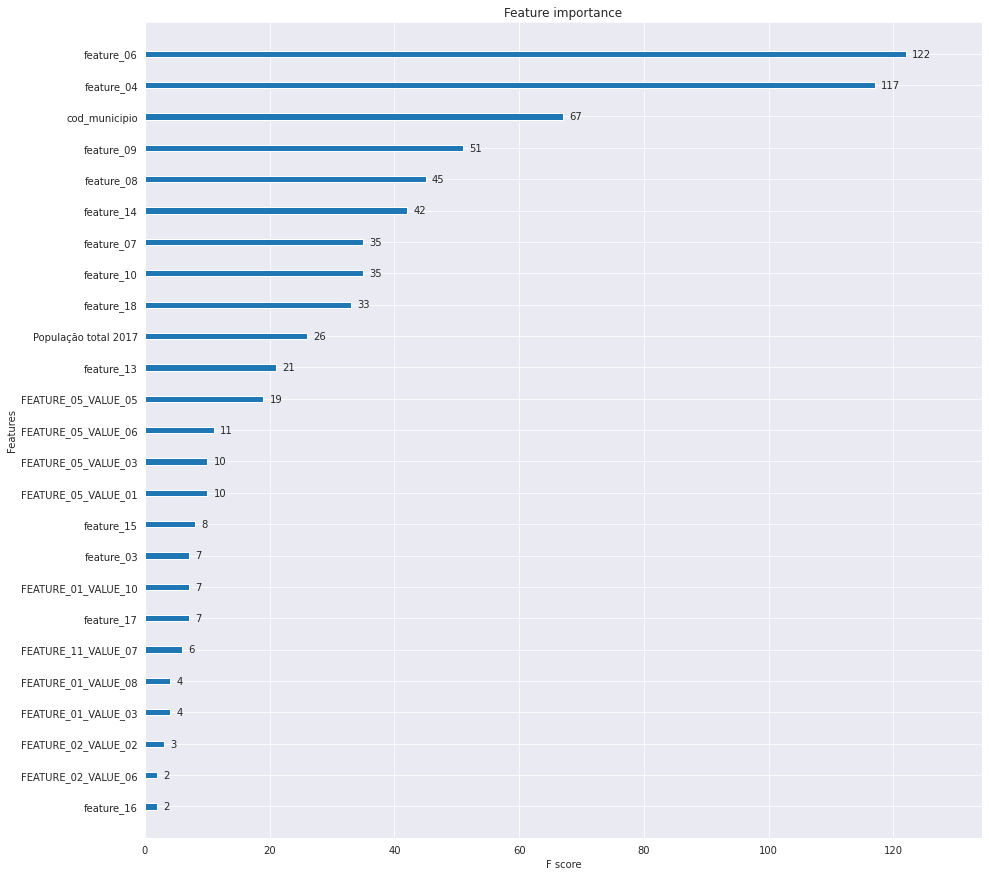

In [68]:
# plot feature importance
fig, ax = plt.subplots(1,1,figsize=(15,15))
plot_importance(model_jan, ax=ax)
plt.show()

In [69]:
removed_nan = data.dropna(0,subset=["2017_2"])

In [70]:
features = ['cod_municipio', 'feature_03', 'feature_04',
       'feature_06', 'feature_07', 'feature_08', 'feature_09', 'feature_10',
       'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17',
       'feature_18', 'FEATURE_01_VALUE_03', 'FEATURE_01_VALUE_06',
       'FEATURE_01_VALUE_08', 'FEATURE_01_VALUE_10', 'FEATURE_02_VALUE_02',
       'FEATURE_02_VALUE_03', 'FEATURE_02_VALUE_04', 'FEATURE_02_VALUE_06',
       'FEATURE_05_VALUE_01', 'FEATURE_05_VALUE_02', 'FEATURE_05_VALUE_03',
       'FEATURE_05_VALUE_04', 'FEATURE_05_VALUE_05', 'FEATURE_05_VALUE_06',
       'FEATURE_05_VALUE_07', 'FEATURE_11_VALUE_01',
       'FEATURE_11_VALUE_02', 'FEATURE_11_VALUE_06', 
       'FEATURE_11_VALUE_07', 'FEATURE_12_VALUE_01', 'FEATURE_12_VALUE_02',
        'População total 2017']
X = removed_nan[features]
target = ['2017_2']
Y = removed_nan[target]

In [71]:
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

In [72]:
model_fev = xgboost.XGBRegressor(objective="reg:squarederror", random_state=42)

In [73]:
score = cross_val_score(model_fev, X_train, y_train, scoring="neg_root_mean_squared_error", cv=5)
display_scores(np.sqrt(-score))

Scores: [194.93927474 189.18300344 187.73439902 191.25725447 186.45765256]
Mean: 189.91431684462341
Standard deviation: 2.97620806977774


In [74]:
model_jan = model_fev.fit(X_train, y_train)
y_pred = model_fev.predict(X_test)
mean_squared_error(y_test,y_pred)

1316782751.9076555

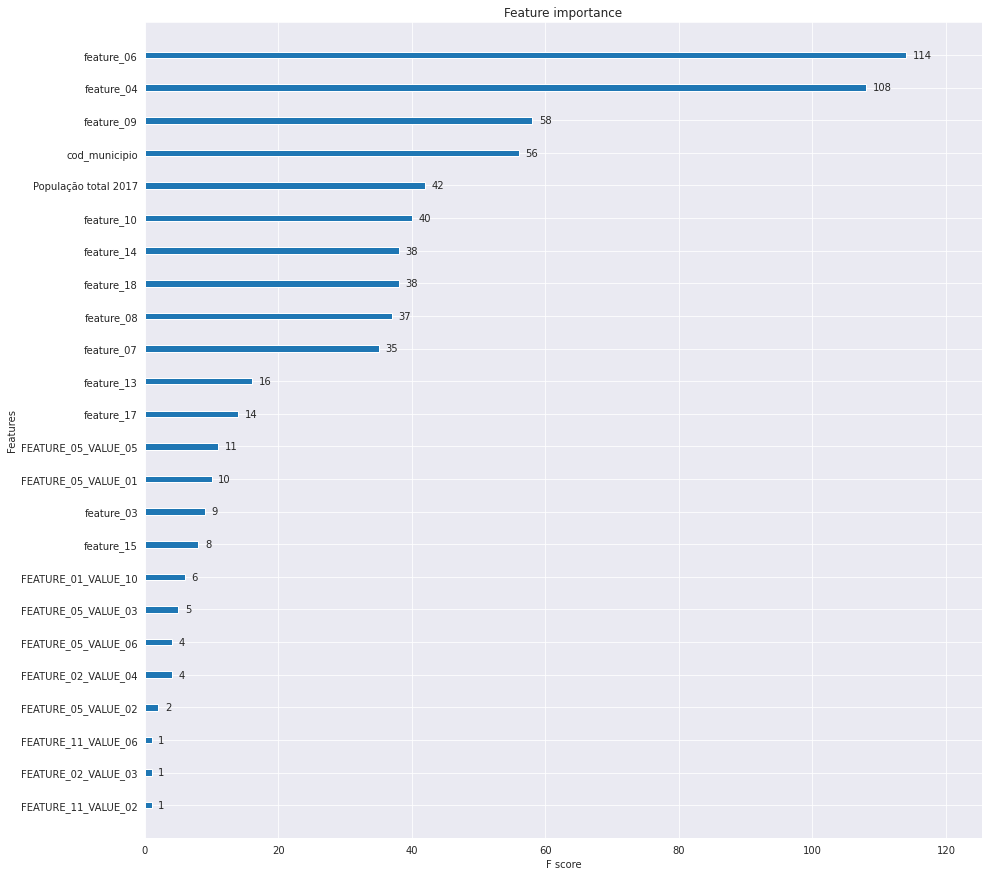

In [75]:
# plot feature importance
fig, ax = plt.subplots(1,1,figsize=(15,15))
plot_importance(model_fev, ax=ax)
plt.show()

In [76]:
removed_nan = data.dropna(0,subset=["2017_3"])

In [77]:
features = ['cod_municipio', 'feature_03', 'feature_04',
       'feature_06', 'feature_07', 'feature_08', 'feature_09', 'feature_10',
       'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17',
       'feature_18', 'FEATURE_01_VALUE_03', 'FEATURE_01_VALUE_06',
       'FEATURE_01_VALUE_08', 'FEATURE_01_VALUE_10', 'FEATURE_02_VALUE_02',
       'FEATURE_02_VALUE_03', 'FEATURE_02_VALUE_04', 'FEATURE_02_VALUE_06',
       'FEATURE_05_VALUE_01', 'FEATURE_05_VALUE_02', 'FEATURE_05_VALUE_03',
       'FEATURE_05_VALUE_04', 'FEATURE_05_VALUE_05', 'FEATURE_05_VALUE_06',
       'FEATURE_05_VALUE_07', 'FEATURE_11_VALUE_01',
       'FEATURE_11_VALUE_02', 'FEATURE_11_VALUE_06', 
       'FEATURE_11_VALUE_07', 'FEATURE_12_VALUE_01', 'FEATURE_12_VALUE_02',
        'População total 2017']
X = removed_nan[features]
target = ['2017_3']
Y = removed_nan[target]

In [78]:
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

In [79]:
model_mar = xgboost.XGBRegressor(objective="reg:squarederror", random_state=42)

In [80]:
score = cross_val_score(model_mar, X_train, y_train, scoring="neg_root_mean_squared_error", cv=5)
display_scores(np.sqrt(-score))

Scores: [217.5006285  200.97533543 206.96752308 210.49169379 207.14990389]
Mean: 208.61701693804343
Standard deviation: 5.3981758872947685


In [81]:
model_mar = model_mar.fit(X_train, y_train)
y_pred = model_mar.predict(X_test)
mean_squared_error(y_test,y_pred)

1770674904.4219131

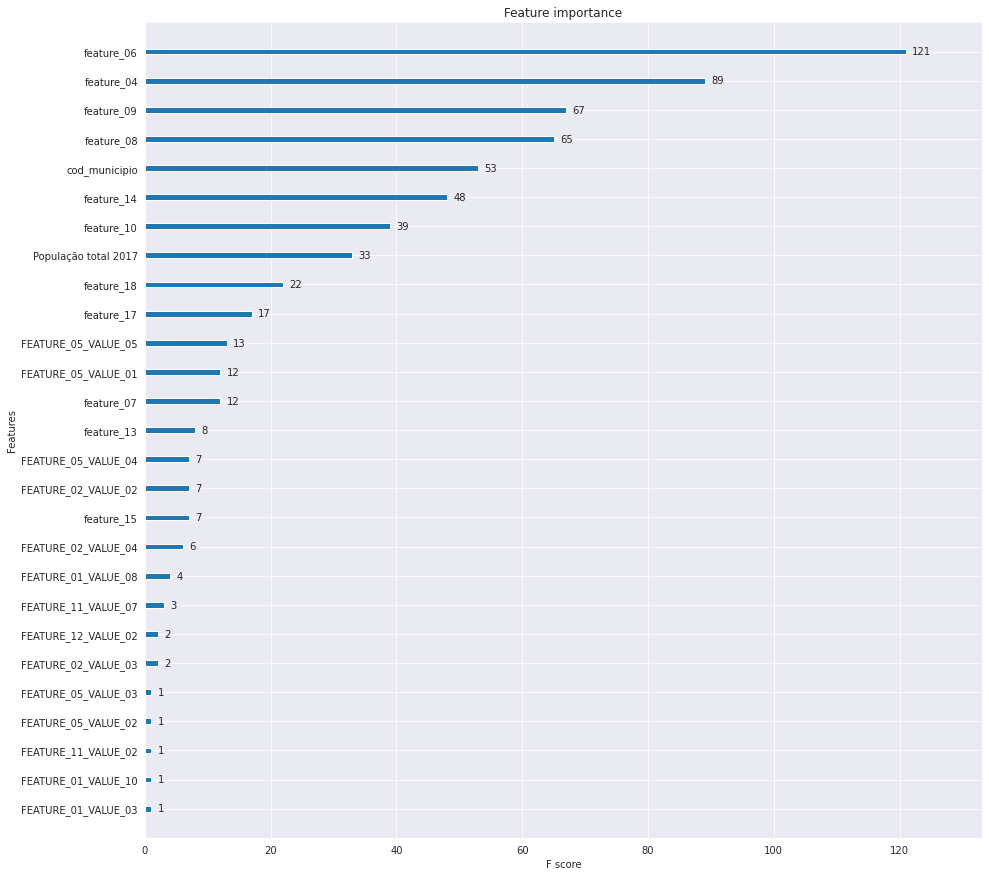

In [82]:
# plot feature importance
fig, ax = plt.subplots(1,1,figsize=(15,15))
plot_importance(model_mar, ax=ax)
plt.show()

#### Criando a submissão

In [83]:
features = ['cod_municipio', 'feature_03', 'feature_04',
       'feature_06', 'feature_07', 'feature_08', 'feature_09', 'feature_10',
       'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17',
       'feature_18', 'FEATURE_01_VALUE_03', 'FEATURE_01_VALUE_06',
       'FEATURE_01_VALUE_08', 'FEATURE_01_VALUE_10', 'FEATURE_02_VALUE_02',
       'FEATURE_02_VALUE_03', 'FEATURE_02_VALUE_04', 'FEATURE_02_VALUE_06',
       'FEATURE_05_VALUE_01', 'FEATURE_05_VALUE_02', 'FEATURE_05_VALUE_03',
       'FEATURE_05_VALUE_04', 'FEATURE_05_VALUE_05', 'FEATURE_05_VALUE_06',
       'FEATURE_05_VALUE_07', 'FEATURE_11_VALUE_01',
       'FEATURE_11_VALUE_02', 'FEATURE_11_VALUE_06', 
       'FEATURE_11_VALUE_07', 'FEATURE_12_VALUE_01', 'FEATURE_12_VALUE_02','População total 2017']
X = metadata_cenarios[features]

In [84]:
X["População total 2017"] = X["População total 2017"].astype(float)

/home/felipemarcelino/.conda/envs/hackaton_big_data/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [85]:
sub = pd.DataFrame(columns=["cod_loja","faturamento","jan","fev","mar"])
sub["cod_loja"] = cenarios["cod_loja"].values
sub["jan"] = model_jan.predict(X)
sub["fev"] = model_fev.predict(X)
sub["mar"] = model_mar.predict(X)
sub["faturamento"] = (sub["jan"].values + sub["fev"].values + sub["mar"].values)/3
sub["faturamento"].sum()
sub.to_csv("./results/sub_2_v2.csv")
desafio_2 = sub[["cod_loja","faturamento"]]
desafio_2.head()
desafio_2.to_csv("./results/desafio_2_v2.csv",index=False,sep=";")


### Usando os dados de IDH e População

In [86]:
removed_nan = data.dropna(0,subset=["2017_1"])

In [87]:
features = ['cod_municipio', 'feature_03', 'feature_04',
       'feature_06', 'feature_07', 'feature_08', 'feature_09', 'feature_10',
       'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17',
       'feature_18', 'FEATURE_01_VALUE_03', 'FEATURE_01_VALUE_06',
       'FEATURE_01_VALUE_08', 'FEATURE_01_VALUE_10', 'FEATURE_02_VALUE_02',
       'FEATURE_02_VALUE_03', 'FEATURE_02_VALUE_04', 'FEATURE_02_VALUE_06',
       'FEATURE_05_VALUE_01', 'FEATURE_05_VALUE_02', 'FEATURE_05_VALUE_03',
       'FEATURE_05_VALUE_04', 'FEATURE_05_VALUE_05', 'FEATURE_05_VALUE_06',
       'FEATURE_05_VALUE_07', 'FEATURE_11_VALUE_01',
       'FEATURE_11_VALUE_02', 'FEATURE_11_VALUE_06', 
       'FEATURE_11_VALUE_07', 'FEATURE_12_VALUE_01', 'FEATURE_12_VALUE_02',
        'População total 2017','IDHM 2010','IDHM Renda 2010','IDHM Longevidade 2010',
        'Renda per capita 2010']
X = removed_nan[features]
target = ['2017_1']
Y = removed_nan[target]

In [88]:
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

In [89]:
model_jan = xgboost.XGBRegressor(objective="reg:squarederror", random_state=42)

In [90]:
score = cross_val_score(model_jan, X_train, y_train, scoring="neg_root_mean_squared_error", cv=5)
display_scores(np.sqrt(-score))

Scores: [210.970093   205.17816397 210.73868994 207.70658856 209.65553497]
Mean: 208.84981408818658
Standard deviation: 2.1679760134676442


In [91]:
model_mar = model_jan.fit(X_train, y_train)
y_pred = model_jan.predict(X_test)
mean_squared_error(y_test,y_pred)

1651296854.322644

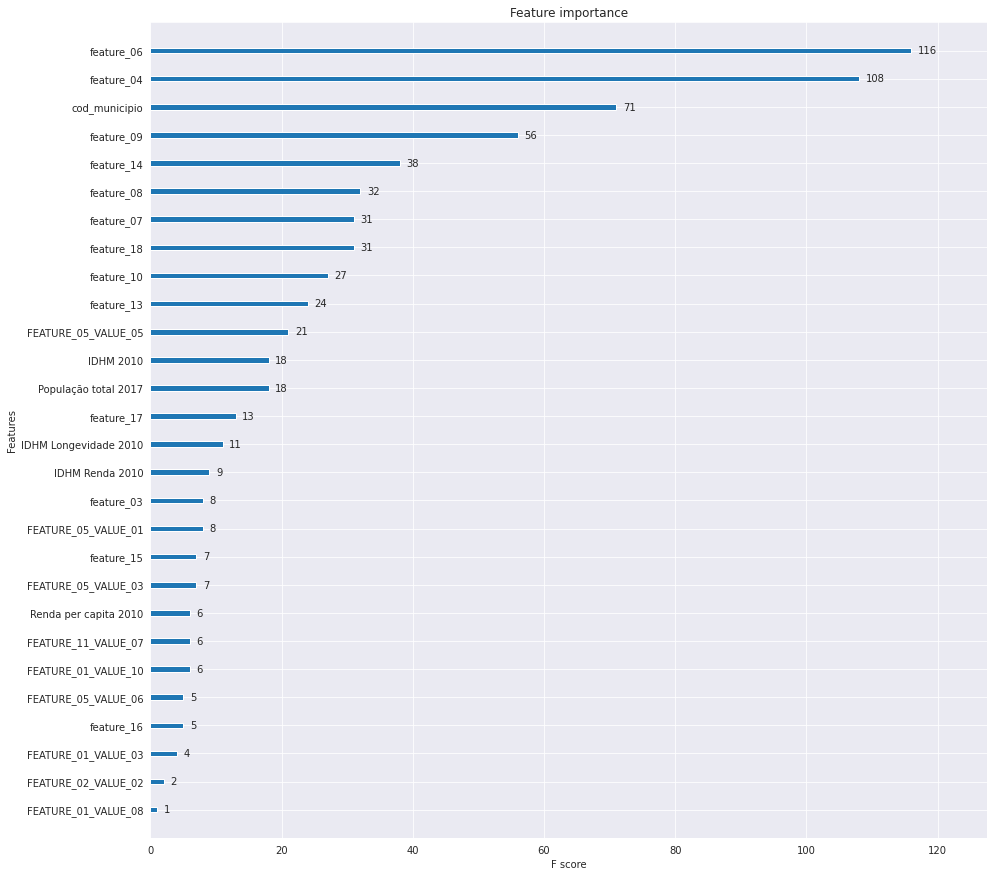

In [92]:
# plot feature importance
fig, ax = plt.subplots(1,1,figsize=(15,15))
plot_importance(model_jan, ax=ax)
plt.show()

In [93]:
removed_nan = data.dropna(0,subset=["2017_2"])

In [94]:
features = ['cod_municipio', 'feature_03', 'feature_04',
       'feature_06', 'feature_07', 'feature_08', 'feature_09', 'feature_10',
       'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17',
       'feature_18', 'FEATURE_01_VALUE_03', 'FEATURE_01_VALUE_06',
       'FEATURE_01_VALUE_08', 'FEATURE_01_VALUE_10', 'FEATURE_02_VALUE_02',
       'FEATURE_02_VALUE_03', 'FEATURE_02_VALUE_04', 'FEATURE_02_VALUE_06',
       'FEATURE_05_VALUE_01', 'FEATURE_05_VALUE_02', 'FEATURE_05_VALUE_03',
       'FEATURE_05_VALUE_04', 'FEATURE_05_VALUE_05', 'FEATURE_05_VALUE_06',
       'FEATURE_05_VALUE_07', 'FEATURE_11_VALUE_01',
       'FEATURE_11_VALUE_02', 'FEATURE_11_VALUE_06', 
       'FEATURE_11_VALUE_07', 'FEATURE_12_VALUE_01', 'FEATURE_12_VALUE_02',
        'População total 2017','IDHM 2010','IDHM Renda 2010','IDHM Longevidade 2010',
        'Renda per capita 2010']
X = removed_nan[features]
target = ['2017_2']
Y = removed_nan[target]

In [95]:
X["População total 2017"] = X["População total 2017"].astype(float)

/home/felipemarcelino/.conda/envs/hackaton_big_data/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [96]:
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

In [97]:
model_fev = xgboost.XGBRegressor(objective="reg:squarederror", random_state=42)

In [98]:
score = cross_val_score(model_fev, X_train, y_train, scoring="neg_root_mean_squared_error", cv=5)
display_scores(np.sqrt(-score))

Scores: [194.31488457 191.12979431 186.92021223 189.46693779 185.88156983]
Mean: 189.54267974548694
Standard deviation: 3.0192605054284916


In [99]:
model_mar = model_fev.fit(X_train, y_train)
y_pred = model_fev.predict(X_test)
mean_squared_error(y_test,y_pred)

1323600494.1822453

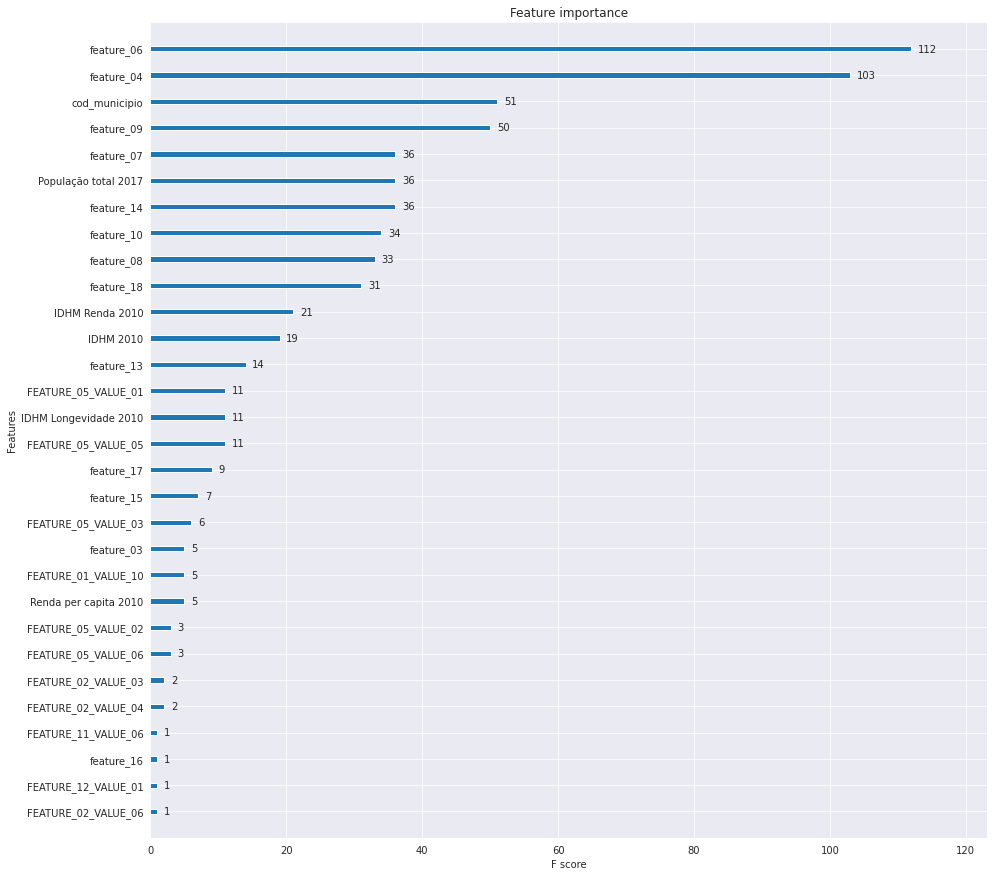

In [100]:
# plot feature importance
fig, ax = plt.subplots(1,1,figsize=(15,15))
plot_importance(model_fev, ax=ax)
plt.show()

In [101]:
removed_nan = data.dropna(0,subset=["2017_3"])

In [102]:
features = ['cod_municipio', 'feature_03', 'feature_04',
       'feature_06', 'feature_07', 'feature_08', 'feature_09', 'feature_10',
       'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17',
       'feature_18', 'FEATURE_01_VALUE_03', 'FEATURE_01_VALUE_06',
       'FEATURE_01_VALUE_08', 'FEATURE_01_VALUE_10', 'FEATURE_02_VALUE_02',
       'FEATURE_02_VALUE_03', 'FEATURE_02_VALUE_04', 'FEATURE_02_VALUE_06',
       'FEATURE_05_VALUE_01', 'FEATURE_05_VALUE_02', 'FEATURE_05_VALUE_03',
       'FEATURE_05_VALUE_04', 'FEATURE_05_VALUE_05', 'FEATURE_05_VALUE_06',
       'FEATURE_05_VALUE_07', 'FEATURE_11_VALUE_01',
       'FEATURE_11_VALUE_02', 'FEATURE_11_VALUE_06', 
       'FEATURE_11_VALUE_07', 'FEATURE_12_VALUE_01', 'FEATURE_12_VALUE_02',
        'População total 2017','IDHM 2010','IDHM Renda 2010','IDHM Longevidade 2010',
        'Renda per capita 2010']
X = removed_nan[features]
target = ['2017_3']
Y = removed_nan[target]

In [103]:
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

In [104]:
model_mar = xgboost.XGBRegressor(objective="reg:squarederror", random_state=42)

In [105]:
score = cross_val_score(model_mar, X_train, y_train, scoring="neg_root_mean_squared_error", cv=5)
display_scores(np.sqrt(-score))

Scores: [216.18045928 202.70681549 207.08467356 210.32885964 208.48896874]
Mean: 208.95795534265926
Standard deviation: 4.401132223308891


In [106]:
model_mar = model_mar.fit(X_train, y_train)
y_pred = model_mar.predict(X_test)
mean_squared_error(y_test,y_pred)

1774719891.0740142

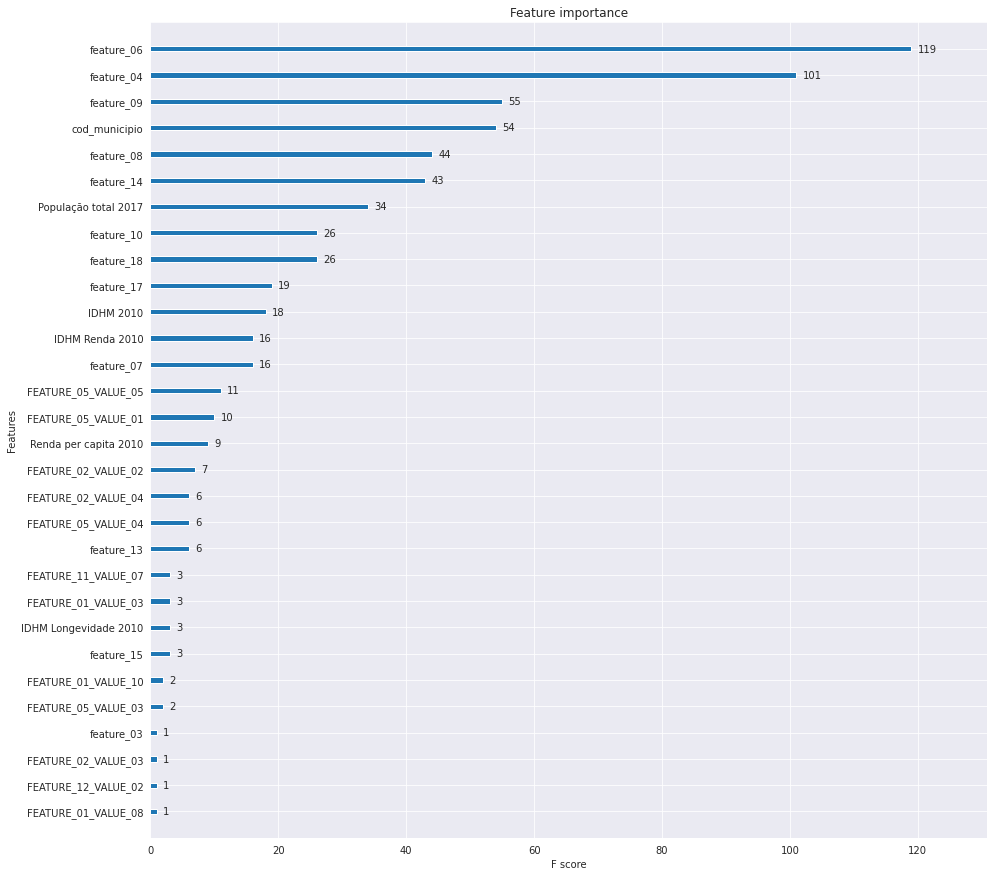

In [107]:
# plot feature importance
fig, ax = plt.subplots(1,1,figsize=(15,15))
plot_importance(model_mar, ax=ax)
plt.show()

#### Criando submissão

In [108]:
features = ['cod_municipio', 'feature_03', 'feature_04',
       'feature_06', 'feature_07', 'feature_08', 'feature_09', 'feature_10',
       'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17',
       'feature_18', 'FEATURE_01_VALUE_03', 'FEATURE_01_VALUE_06',
       'FEATURE_01_VALUE_08', 'FEATURE_01_VALUE_10', 'FEATURE_02_VALUE_02',
       'FEATURE_02_VALUE_03', 'FEATURE_02_VALUE_04', 'FEATURE_02_VALUE_06',
       'FEATURE_05_VALUE_01', 'FEATURE_05_VALUE_02', 'FEATURE_05_VALUE_03',
       'FEATURE_05_VALUE_04', 'FEATURE_05_VALUE_05', 'FEATURE_05_VALUE_06',
       'FEATURE_05_VALUE_07', 'FEATURE_11_VALUE_01',
       'FEATURE_11_VALUE_02', 'FEATURE_11_VALUE_06', 
       'FEATURE_11_VALUE_07', 'FEATURE_12_VALUE_01', 'FEATURE_12_VALUE_02',
        'População total 2017','IDHM 2010','IDHM Renda 2010','IDHM Longevidade 2010',
        'Renda per capita 2010']
X = metadata_cenarios[features]

In [109]:
X["População total 2017"] = X["População total 2017"].astype(float)

/home/felipemarcelino/.conda/envs/hackaton_big_data/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [110]:
sub = pd.DataFrame(columns=["cod_loja","faturamento","jan","fev","mar"])
sub["cod_loja"] = cenarios["cod_loja"].values
sub["jan"] = model_jan.predict(X)
sub["fev"] = model_fev.predict(X)
sub["mar"] = model_mar.predict(X)
sub["faturamento"] = (sub["jan"].values + sub["fev"].values + sub["mar"].values)/3
sub["faturamento"].sum()
sub.to_csv("./results/sub_2_v3.csv")
desafio_2 = sub[["cod_loja","faturamento"]]
desafio_2.head()
desafio_2.to_csv("./results/desafio_2_v3.csv",index=False,sep=";")


## Conclusão

As feature_06, feature_04 e feature_09 dos metadados tiveram destaca nesse modelo. Em alguns modelos a feature contendo o total da população de 2017 se destacou, e como no modelo anterior, as features contendo IDHM e PIB tiveram relevância média dentro da modelagem. 